In [ ]:
library(rjson)
library(dplyr)
library(ggplot2)
library(reshape2)
library(ggrepel)
library(gplots)
library(seqinr)
library("IRdisplay")
library(png)

library(geepack)
library(foreach)
library(parallel)
library(doParallel)
# library(doMC)

library(reticulate)
glypy <- import('glypy')

library(dplyr)

setwd('C:/Users/benja/bpk Dropbox/Benjamin Kellman/working_dir/projects/GTspecificity/')
source('code/functions.r')
source('code/unit_tests.r')
source('code/stats.r')
source('code/network_vis.r')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'seqinr'


The following object is masked from 'package:dplyr':

    count


Loading required package: iterators

Warning message in system2(command = python, args = shQuote(script), stdout = TRUE, :
"running command '"C:/Users/benja/OneDrive/Documents/.virtualenvs/r-reticulate/Scripts/python.exe" "C:/Users/benja/miniconda3/envs/r/Lib/R/library/reticulate/config/config.py"' had status 103"


Error in python_config_impl(python) : 
  Error 103 occurred running C:/Users/benja/OneDrive/Documents/.virtualenvs/r-reticulate/Scripts/python.exe: 


Warning message:
"package 'glmnet' was built under R version 4.4.1"
Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: lattice



In [1]:
setwd('C:/Users/benja/bpk Dropbox/Benjamin Kellman/working_dir/projects/GTspecificity/')


In [ ]:
# BiocManager::install("mixOmics",force=T)
# install.packages('dummies')
# library(devtools)
# install_github("andland/generalizedPCA")


In [ ]:


##############################################################################################
##########################################################	INPUT
##############################################################################################

run_GEE=F

types = list(N=c('ASN'),O=c('SER','THR') ) #,C='TRP')

unicarb_file = 'annotation/01_webscrape/unicarb.in.csv'
file_glycan_structure = 'annotation/01_webscrape/glytoucan_motif.out.csv'
# file_protein_structure = 'annotation/02_structure_annot/protein_structure_info.just_unicarbkb.csv'
# file_protein_structure_motif = 'annotation/03_protein_site_stats/protein_structure_motif.just_unicarbkb.rda'
file_protein_structure = 'annotation/02_structure_annot/protein_structure_info.just_glyco.csv'
file_protein_structure_motif = 'annotation/03_protein_site_stats/protein_structure_motif.just_glyco.rda'
#uncarb_glytoucan_motif_file = '/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GTspecificity/annotation/01_webscrape/unicarb_glytoucan_motif.out.csv'
heirin = fromJSON(paste(readLines('annotation/01_webscrape/Motif_Hierarchy.json'), collapse=""))
# motif_vector = fromJSON(paste(readLines('~/Desktop/Unicarbkb_motif_vec_12259.json'), collapse=""))
motif_vector = fromJSON(paste(readLines(motif_f<-'annotation/Unicarbkb_motif_vec_12259.json'), collapse=""))



##############################################################################################
##############################################################################################
##############################################################################################


get_reps<-function(motifs,weights=rep(1,length(motifs)),thresh=1){
    library(reticulate)
    
    glycompare <- import('glycompare')

    for(i in 1:length(motifs)){
        a_panel = glycompare$nglycan_alignment$glycan_model()
        gi=glypy$io$glycoct$loads(motifs[i])
        #print(gi)
        try( gly_nglycan_dict <- glycompare$nglycan_alignment$traves_glycan(gi, weight=weights[i]))
        try( a_panel$glycan_walk(gly_nglycan_dict))
        #plot_glycan_utilities.plot_glycan(a_panel.get_common_representative(0.1), title=0.1)
    }
    rep_glycan = a_panel$get_reps(threshold=thresh)
    return(rep_glycan)
}

count_prots_modeled<-function(gv,pv,sequon){
    dat = droplevels(na.omit(pstruc_annot_motif[pstruc_annot_motif$sequon_aa %in% sequon,
                                    c('uniprotID','sequon_aa',gv,pv,'cscore' )]))
    head(tab<-as.data.frame(table(prot=dat$uniprotID,Xi=dat[[gv]])))
    c(nprot = length(unique(tab$prot)),
    nprotpres = sum(tab$Freq[tab$Xi==1]>0),nglypres = sum(tab$Freq[tab$Xi==1]),
    nprotabs = sum(tab$Freq[tab$Xi==0]>0), nglyabs = sum(tab$Freq[tab$Xi==0]))
}




In [ ]:

if(file.exists(motif_f)){
    motif_ms_occurance = read.csv(motif_f)
}else{
    ms_comp=as.data.frame(do.call(rbind,lapply(1:length(motif_vector),function(i) cbind(motif=paste0('X',i-1),ms=unlist(lapply(glypy$io$glycoct$loads(motif_vector[i])$index,glypy$io$iupac$dumps))))))
    motif_ms_occurance=with(ms_comp,table(motif,ms))
    write.csv(motif_ms_occurance,file=motif_f)
}

In [ ]:
# if(file.exists('~/Desktop/Unicarbkb_motif_vec_12259.monosaccharides.csv')){
#     motif_ms_occurance = read.csv('~/Desktop/Unicarbkb_motif_vec_12259.monosaccharides.csv')
# }else{
#     ms_comp=as.data.frame(do.call(rbind,lapply(1:length(motif_vector),function(i) cbind(motif=paste0('X',i-1),ms=unlist(lapply(glypy$io$glycoct$loads(motif_vector[i])$index,glypy$io$iupac$dumps))))))
#     motif_ms_occurance=with(ms_comp,table(motif,ms))
#     write.csv(motif_ms_occurance,file='~/Desktop/Unicarbkb_motif_vec_12259.monosaccharides.csv')
# }

In [ ]:
# file_protein_structure_motif = 'annotation/03_protein_site_stats/protein_structure_motif.just_glyco.rda'

load(file_protein_structure_motif) # source('02c_merge.r')
UNICARB_PSTRUC_GSTRUC$index = 1:nrow(UNICARB_PSTRUC_GSTRUC)

In [ ]:
dim(na.omit(UNICARB_PSTRUC_GSTRUC))

In [ ]:
# glycan count
table(UNICARB_PSTRUC_GSTRUC$sequon_aa)
# glycan type by protein
tab=table(UNICARB_PSTRUC_GSTRUC$uniprotID, UNICARB_PSTRUC_GSTRUC$sequon_aa)
tabn=tab[rowSums(tab)>0,1]
print(paste('Proteins with N-glycans',sum(tabn>0)))
tabo=tab[rowSums(tab)>0,2:4]
print(paste('Proteins with O-glycans',sum(tabo>0)))

options(repr.plot.width=20)
glyperprot=UNICARB_PSTRUC_GSTRUC %>% 
    filter(!is.na(UNICARB_PSTRUC_GSTRUC$sequon_aa)) %>%
    mutate( uniprotID = factor( uniprotID , levels = (unip<-names(sort(table(UNICARB_PSTRUC_GSTRUC$uniprotID))))) )
    # table(tmp$uniprotID,tmp$sequon_aa) %>% melt(varnames = c('uniprotID','sequon_aa'),value.name = 'count') %>% filter (count>0) %>%
g1=ggplot(glyperprot,aes(x=uniprotID,fill=sequon_aa))+
    geom_bar()+scale_fill_brewer()+#facet_grid(sequon_aa~.)+
    theme_bw(base_size=15)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

g1




In [ ]:



senperprot=UNICARB_PSTRUC_GSTRUC %>% 
    filter(!is.na(UNICARB_PSTRUC_GSTRUC$sequon_aa)) %>%
    mutate( uniprotID = factor( uniprotID , levels = names(sort(table(UNICARB_PSTRUC_GSTRUC$uniprotID)))))  
# senperprot=    table(tmp$uniprotID,tmp$sequon,tmp$sequon_aa) %>% 
    # melt(varnames = c('uniprotID','sequon','sequon_aa'),value.name = 'count') %>% filter(count>0)

# head(senperprot)

g2=senperprot %>% group_by(uniprotID,sequon_aa,sequon) %>% summarise(count=length(sequon_aa)) %>%
    group_by(uniprotID,sequon_aa) %>% summarise(count=length(sequon_aa)) %>%
    # mutate( uniprotID = factor( uniprotID , levels = unique(uniprotID[count]))) %>%
    ggplot(aes(x=uniprotID,fill=sequon_aa,y=count))+
    geom_bar(stat='identity')+scale_fill_brewer()+#facet_grid(sequon_aa~.)+
    theme_bw(base_size=15)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
g2

In [ ]:
g3=merge(
    table(glyperprot$uniprotID,glyperprot$sequon_aa) %>% 
        melt(varnames = c('uniprotID','sequon_aa'),value.name = 'glycan_count') %>% filter (glycan_count>0),
    senperprot %>% group_by(uniprotID,sequon_aa,sequon) %>% summarise(count=length(sequon_aa)) %>%
        group_by(uniprotID,sequon_aa) %>% summarise(sequon_count=length(sequon_aa))) %>%
    ggplot(aes(x=glycan_count,y=sequon_count,color=sequon_aa,shape=sequon_aa))+
        geom_jitter(size=4)+scale_color_brewer()+
        scale_x_log10()+scale_y_log10()+
        theme_bw(base_size=20)
g3

In [ ]:
g4=merge(
    table(glyperprot$uniprotID,glyperprot$sequon_aa) %>% 
        melt(varnames = c('uniprotID','sequon_aa'),value.name = 'glycan_count') %>% filter (glycan_count>0),
    senperprot %>% group_by(uniprotID,sequon_aa,sequon) %>% summarise(count=length(sequon_aa)) %>%
        group_by(uniprotID,sequon_aa) %>% summarise(sequon_count=length(sequon_aa))) %>%
    melt() %>%
    ggplot(aes(x=variable,y=value))+
        geom_point()+
        geom_boxplot()+
        scale_y_log10()+
        theme_bw(base_size = 20)
g4

In [ ]:
options(repr.plot.width=20,repr.plot.height=15)

cowplot::plot_grid(
    cowplot::plot_grid(
        g1+theme(legend.position = 'none'),
        g2+theme(legend.position = 'none'),nrow =2 ),
    cowplot::plot_grid(g3,g4),
    rel_widths = c(.7,.3),nrow=2,rel_heights=c(.6,.3))
ggsave('figures//database_coverage/03_protein_sequon_glycan.count.pdf',width=15,height =15)

In [ ]:

###################
################ LOAD DATASETS
##############################
UNICARB_PSTRUC_GSTRUC = UNICARB_PSTRUC_GSTRUC[!is.na(UNICARB_PSTRUC_GSTRUC$unicarbID),] # exctract just unicarb

In [ ]:
(str(UNICARB_PSTRUC_GSTRUC[,1:100]))
#colnames(UNICARB_PSTRUC_GSTRUC[,1:200])

In [ ]:
#str_vars = high_impact
pstruc_annot_motif=UNICARB_PSTRUC_GSTRUC
str_vars = grep('\\.',colnames(pstruc_annot_motif),value=T)
substr_vars = grep('^X[0-9]',colnames(pstruc_annot_motif),value=T)

In [ ]:
tmp=model.matrix(~0+.,data=UNICARB_PSTRUC_GSTRUC[,c(str_vars,substr_vars,'index')])
pstruc_annot_motif=cbind(pstruc_annot_motif[tmp[,'index'],c('uniprotID','sequon_aa','cscore')],as.data.frame(tmp))
str_vars = grep('\\.',colnames(pstruc_annot_motif),value=T)
str_vars = str_vars[!grepl('seq_RSA.accpro-|struct_SS.dssp-',str_vars)]

In [ ]:
str_vars

In [ ]:
# table(UNICARB_PSTRUC_GSTRUC$sequon_aa)
# rowSums(table(UNICARB_PSTRUC_GSTRUC$sequon_aa,UNICARB_PSTRUC_GSTRUC$uniprotID)>0)
# 700/3563

In [ ]:
table(pstruc_annot_motif$X0,pstruc_annot_motif$seq_aaUp.L)

In [ ]:
#library(DescTools)
#Desc(UNICARB_PSTRUC_GSTRUC[,str_vars])

mod_stats_out=list()

# Run GEE

In [ ]:
cl <- makeCluster(30)
registerDoParallel(cl)
#registerDoMC(cl)


In [ ]:

#### QC

if(F){
    pv = 'struct_aa.Y'
    gv = 'X302'
    sequon = 'ASN'

    dat = droplevels(na.omit(pstruc_annot_motif[pstruc_annot_motif$sequon_aa %in% sequon,
                                                c('uniprotID','sequon_aa',pv,gv,'cscore')]))
    table(dat[,gv],(as.numeric(dat[,gv]>0)))
    dat[,gv] = (as.numeric(dat[,gv]>0))
    # check motif occurance count 
    if(sd(dat[,gv])<1e-6 | sum(dat[,gv])<5){stop()}
    # weight-balance labels
    tab=table(dat[,gv])
    weights= ifelse(dat[,gv]=='1',1/tab['1'],1/tab['0']) * 1^dat$cscore
    table(dat[,pv] , dat[,gv])


    tab = table(dat[,pv]>0)
    keep = (dat[,pv]>0) %in% names(tab)[tab>4] # retain only lables with at least 4 occurances
    tab_check = table( dat[keep,pv]>0, dat[keep,gv] )
    if(is.null(tab_check)){next}
    if(any(tab_check<=4) | any(dim(tab_check)<2)){next} # skip model if any cell has 4 instance
    if(any(chisq.test(tab_check)$expected<=5)){next}
    # weight-balance labels
    tab=table(dat[keep,gv])
    weights= ifelse(dat[keep,gv]=='1',1/tab['1'],1/tab['0']) * 2^dat$cscore[keep]

    # run model

    tab=table(pv=dat[keep,pv] , gv=dat[keep,gv])

    tab[,2]/rowSums(tab)

    try(mod<-geeglm(as.formula(paste(gv,'~',pv)),family=binomial(link="logit") , weights = weights,
        id=uniprotID,corstr='exchangeable',data=na.omit(dat[keep,])  ))
    summary(mod)

    dat[,gv] = factor(dat[,gv])
    ggplot(dat[keep,],aes_string(x=pv,fill=gv))+geom_bar(position='fill')
}

In [ ]:
#### run parallel stats
#initi cluster

mod_stats_out=list()

print('start parallel run')
# iterate over protein structure variables
mod_stats_out=foreach( pv=str_vars ,.packages=c('geepack','xtable') ,.combine='c') %dopar% {
#for(pv in str_vars[1:10]){
    print(pv)
    mod_stats=list() ##
    for(gv in substr_vars){
        for(sequon in list(c('ASN'),c("SER","THR"))){
            # make data subset
            dat = droplevels(na.omit(pstruc_annot_motif[pstruc_annot_motif$sequon_aa %in% sequon,
                                                        c('uniprotID','sequon_aa',pv,gv,'cscore')]))
            dat[,gv] = (as.numeric(dat[,gv]>0))
            # check motif occurance count 
            if(sd(dat[,gv])<1e-6 | sum(dat[,gv])<5){next}
            # weight-balance labels
            tab=table(dat[,gv])
            weights= ifelse(dat[,gv]=='1',1/tab['1'],1/tab['0']) * 2^dat$cscore
            # make model
            if(is.numeric(dat[,pv]) & length(table(dat[,pv]))>10){ 
                # weight-balance labels
                tab=table(dat[,gv])
                weights= ifelse(dat[,gv]=='1',1/tab['1'],1/tab['0']) * 2^dat$cscore
                # run model
                try(mod<-geeglm(as.formula(paste(gv,'~scale(',pv,')')),family=binomial ,weights = weights,
                    id=uniprotID,corstr='exchangeable',data=dat  ))
            }else{
                #print('discrete')
                # discrete variable checks
                tab = table(dat[,pv]>0)
                keep = (dat[,pv]>0) %in% names(tab)[tab>4] # retain only lables with at least 4 occurances
                tab_check = table( dat[keep,pv]>0, dat[keep,gv] )
                if(is.null(tab_check)){next}
                if(any(tab_check<=4) | any(dim(tab_check)<2)){next} # skip model if any cell has 4 instance
                if(any(chisq.test(tab_check)$expected<=5)){next}
                # weight-balance labels
                tab=table(dat[keep,gv])
                weights= ifelse(dat[keep,gv]=='1',1/tab['1'],1/tab['0']) * 2^dat$cscore[keep]

                # run model
                try(mod<-geeglm(as.formula(paste(gv,'~',pv)),family=binomial ,weights = weights,
                    id=uniprotID,corstr='exchangeable',data=dat[keep,]  ))
            }

#            try( mod_stats_out[[paste(gv,pv,paste(sequon,collapse='.'),sep='__')]] <- parseSummary.GEEpack(mod,odsig=3,logit=T) )
            try( mod_stats[[paste(gv,pv,paste(sequon,collapse='.'),sep='__')]] <- parseSummary.GEEpack(mod,odsig=3,logit=T) )
        }
    }
    return(mod_stats)
}
    


In [ ]:
str(mod_stats_out)

In [ ]:
print('end parallel run')
try(stopCluster(cl))
gc(reset=T)

In [ ]:
out=do.call(rbind,lapply(mod_stats_out,function(x) cbind( x[[1]], t(data.matrix(x[[2]])) ) ))
colnames(out)=c('coef','CI_95','Pr_w','N_obs','N_clust','MarginalR2','MarginalEntropy',"df",'ShapiroWilksP')
out=out[!grepl('Intercept',rownames(out)) & out$coef<1000 & out$coef>0 ,]
             
tmp=do.call(rbind,strsplit( sapply(strsplit( gsub('scale\\(|\\)','',rownames(out)) , '\\.struct_|\\.seq_'), function(x) x[1]) , '__'))
tmp=cbind(tmp[,-2],do.call(rbind,strsplit(gsub('seq_','seq.',gsub('struct_','struct.',tmp[,2])),'\\.')))
colnames(tmp) =c('motif','sequon','type','tool','measure')
                                   
out = cbind(out,tmp)
        head(out)                 


In [ ]:
obs_counts = t(apply(out[,c('motif','type','tool','measure','sequon')],1,function(x){
    count_prots_modeled(gv = x[1],pv=paste0(x[2],'_',x[3],'.',x[4]),sequon=strsplit(x[5],'\\.')[[1]])
                        }))
str(obs_counts)
head(obs_counts)
if(!all(rownames(out)==rownames(obs_counts))){stop('dim mismatch')}
out = cbind(out,obs_counts)

In [ ]:
##### OPTIONAL: clean up measure/tool distinction

tmp = out
# tmp = out %>% group_by('type','tool','measure') %>% mutate(W_q=p.adjust(Pr_w,'fdr'))
# tmp = as.data.frame(tmp)
tmp$tool = as.character(tmp$tool)
tmp$measure = as.character(tmp$measure)
head(tmp)

#head(unique(tmp[sample(nrow(tmp)),c('tool','type','measure')]))
tmp$tool[tmp$tool=='SS' & tmp$type=='seq' & grepl('sspro8',tmp$measure)] = 'sspro8'
tmp$tool[tmp$tool=='SS' & tmp$type=='seq' ] = 'sspro'
tmp$tool[tmp$tool=='SS' & tmp$type=='struct' ] = 'dssp.SS'

tmp$measure[tmp$measure=='dssp' ] = tmp$tool[idx<-tmp$measure=='dssp' ]
tmp$tool[idx] = 'dssp'

tmp$measure[tmp$measure=='freesasa_het' ] = tmp$tool[idx<-tmp$measure=='freesasa_het' ]
tmp$tool[idx] = 'freesasa_het'

tmp$measure[tmp$measure=='msms' ] = tmp$tool[idx<-tmp$measure=='msms' ]
tmp$tool[idx] = 'msms'

tmp$measure[tmp$measure=='accproe' ] = tmp$tool[idx<-tmp$measure=='accproe' ]
tmp$tool[idx] = 'accproe'

tmp$measure[tmp$measure=='accpro20' ] = tmp$tool[idx<-tmp$measure=='accpro20' ]
tmp$tool[idx] = 'accpro20'

tmp$measure = gsub('sspro|sspro8|dssp','ss.',tmp$measure)

#tmp[,c('tool','type','measure')] = as.matrix(tmp[,c('tool','type','measure')])
out=tmp

In [ ]:
save(mod_stats_out,out,file='annotation/03_protein_site_stats/glyco_stats.rda')

In [ ]:
write.csv(out,file='annotation/03_protein_site_stats/glyco_stats.csv')

## Explore Results

In [1]:
library('alluvial')
library(ggalluvial)
library(dplyr)
setwd('C:/Users/benja/bpk Dropbox/Benjamin Kellman/working_dir/projects/GTspecificity/')


Loading required package: ggplot2


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
load(file='annotation/03_protein_site_stats/glyco_stats.rda')

In [3]:
str((out))

'data.frame':	57564 obs. of  19 variables:
 $ coef           : num  1.01 1 0.901 1.09 1.1 1.01 1.01 0.948 1.08 1 ...
 $ CI_95          : chr  "(0.954 - 1.06)" "(0.95 - 1.06)" "(0.833 - 0.968)" "(0.983 - 1.19)" ...
 $ Pr_w           : num  0.7978 0.8656 0.006 0.0851 0.6613 ...
 $ N_obs          : num  1725 1725 454 1725 1725 ...
 $ N_clust        : num  72 72 17 72 72 72 72 17 72 72 ...
 $ MarginalR2     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ MarginalEntropy: num  0.492 0.501 0.425 0.3 0.268 0.492 0.5 0.494 0.318 -0.0624 ...
 $ df             : num  1723 1723 452 1723 1723 ...
 $ ShapiroWilksP  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ motif          : Factor w/ 1743 levels "X0","X1","X104",..: 1 2 2 637 1117 293 296 296 350 444 ...
 $ sequon         : Factor w/ 2 levels "ASN","SER.THR": 1 1 2 1 1 1 1 2 1 1 ...
 $ type           : Factor w/ 2 levels "seq","struct": 1 1 1 1 1 1 1 1 1 1 ...
 $ tool           : chr  "accproe" "accproe" "accproe" "accproe" ...
 $ measure        : chr  "RSA" "R

### IMR distributions

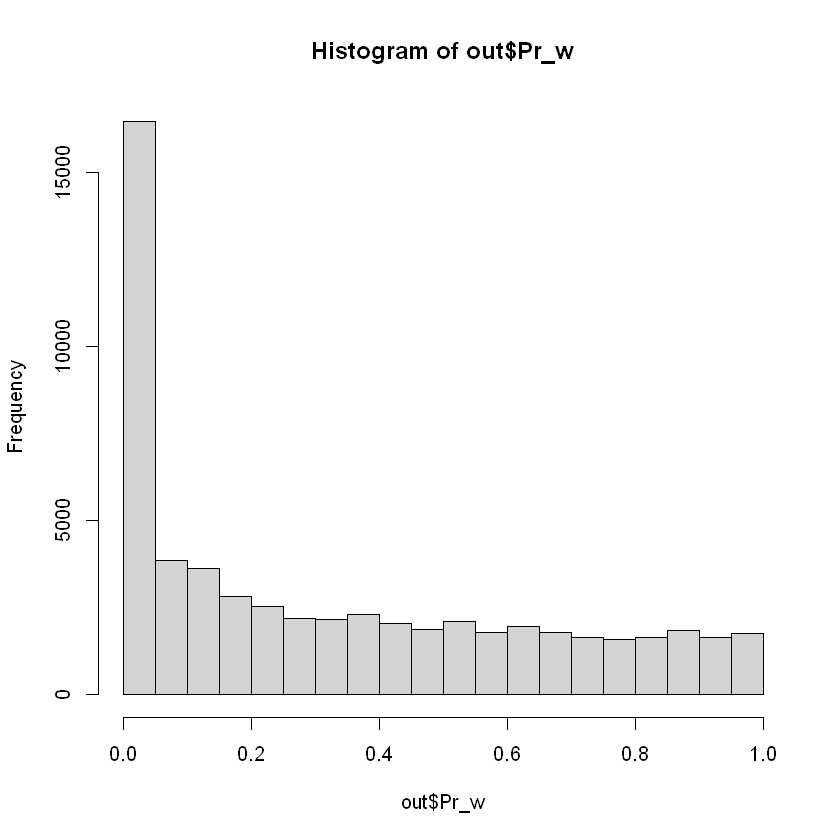

In [4]:
hist(out$Pr_w)

Warning message:
"Removed 88 rows containing missing values or values outside the scale range (`geom_point()`)."


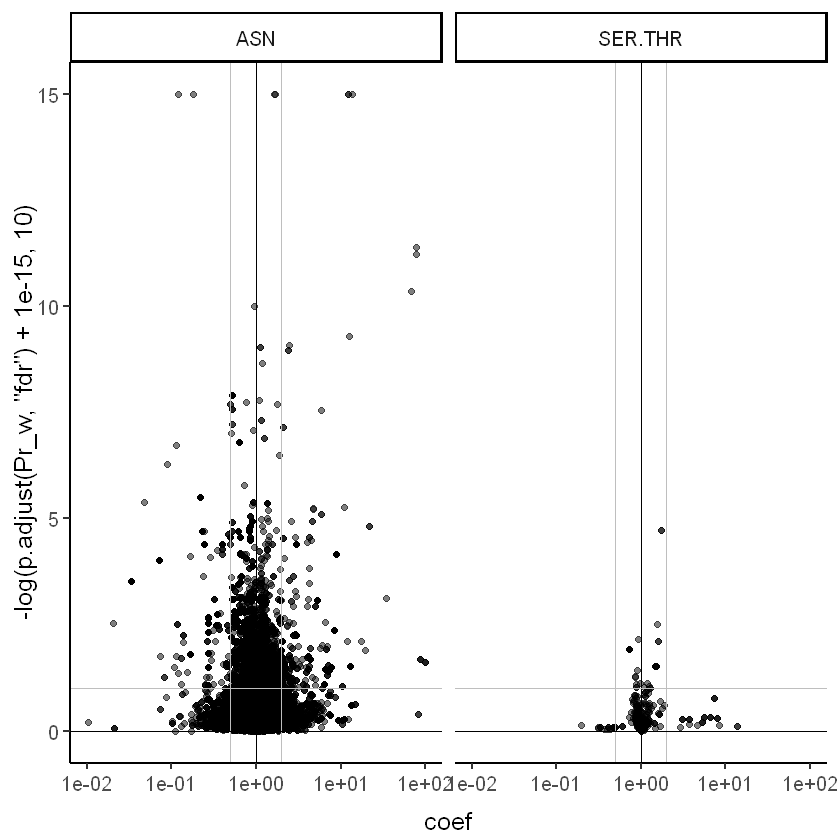

In [5]:
library(ggplot2)
ggplot(data=out,
    aes(x=coef,y=-log(p.adjust(Pr_w,'fdr')+1e-15,10)))+geom_jitter(alpha=.5)+scale_x_log10(lim=c(1e-2,1e2))+
    geom_vline(xintercept=1)+geom_vline(xintercept=.5,color='grey')+geom_vline(xintercept=2,color='grey')+
    geom_hline(yintercept = 0)+geom_hline(yintercept = 1,color='grey')+
    theme_classic(base_size=15)+facet_wrap(~sequon)


In [6]:
with(out[out$sequon=='ASN',],
    table(abs(coef)<.5,p.adjust(Pr_w,'fdr')<.1)
)

with(out[out$sequon=='SER.THR',],
    table(abs(coef)<.5,p.adjust(Pr_w,'fdr')<.1)
)



       
        FALSE  TRUE
  FALSE 42732 11804
  TRUE   1161  1318

       
        FALSE TRUE
  FALSE   517   12
  TRUE     20    0

In [7]:
# head(out[order(out$Pr_w),],n=200)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


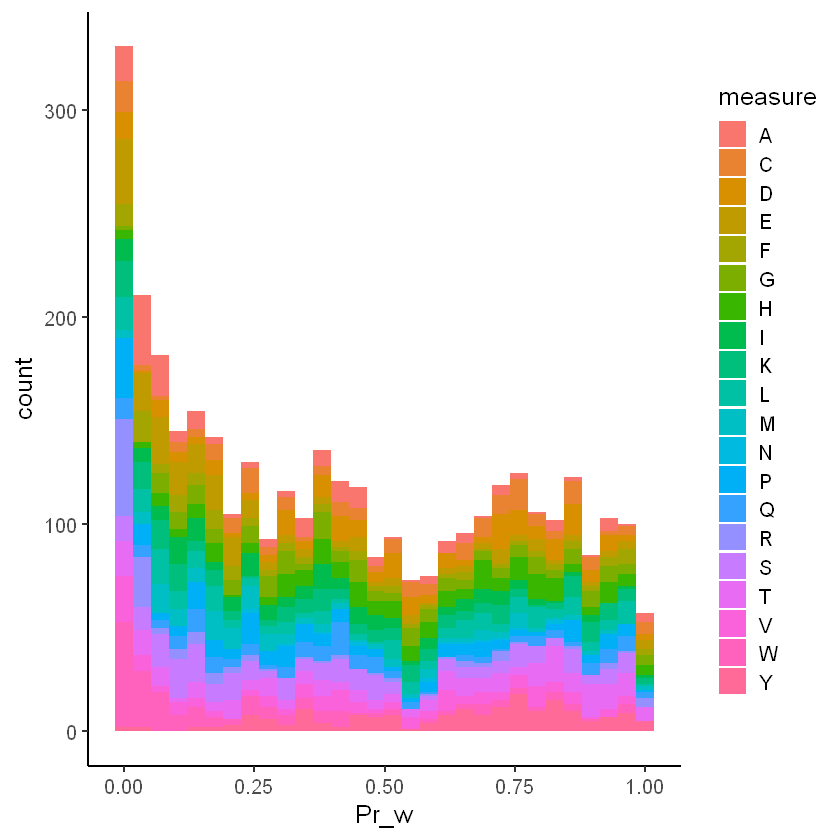

Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


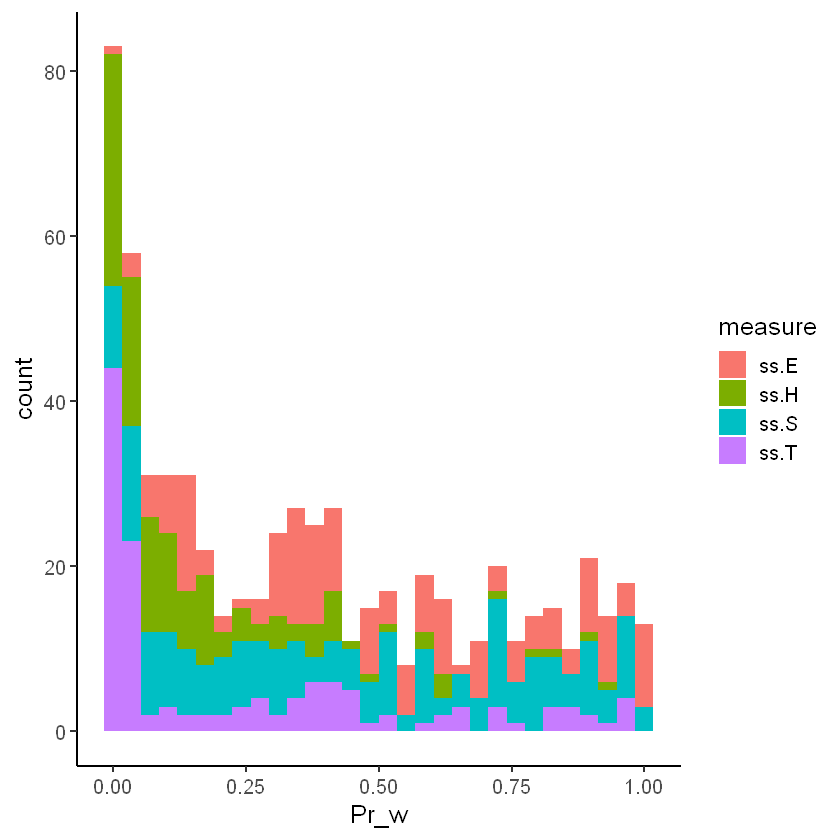

In [8]:
# which protein structures are most associated with glycan structures
library(ggplot2)
g1=ggplot(data=unique(out[out$tool%in%c('aa')&out$type=='struct',c('measure','Pr_w','coef')]),
    aes(x=Pr_w,fill=measure))+geom_histogram()+
    #scale_color_manual(values = 'white')+
    theme_classic(base_size=15)#+facet_wrap(tool~sequon,scales = 'free')
g1

g2=ggplot(data=unique(out[out$tool%in%c('dssp.SS')&out$type=='struct',c('measure','Pr_w','coef')]),
    aes(x=Pr_w,fill=measure))+geom_histogram()+
    theme_classic(base_size=15)#+facet_wrap(tool~sequon,scales = 'free')
g2

ggsave(g1,filename='figures/03.statistical_trends/glycan_protein_assc/p_distr.aa.pdf')
ggsave(g2,filename='figures/03.statistical_trends/glycan_protein_assc/p_distr.SS.pdf')




In [9]:
library('alluvial')
library(ggalluvial)

tmp = unique(out[,c('measure','Pr_w','coef','tool','type')])
tmp = tmp %>% group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.05 ,na.rm=T) ) #%>% arrange(-fq)

write.csv(tmp,file='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.05_distr.all.csv')

head(tmp)

`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.


type,tool,measure,fq
<fct>,<chr>,<chr>,<int>
seq,aaAll,A,18
seq,aaAll,C,8
seq,aaAll,D,37
seq,aaAll,E,12
seq,aaAll,F,46
seq,aaAll,G,1


Warning message:
"Removed 46 rows containing missing values or values outside the scale range (`geom_text()`)."
Warning message:
"Removed 46 rows containing missing values or values outside the scale range (`geom_text()`)."


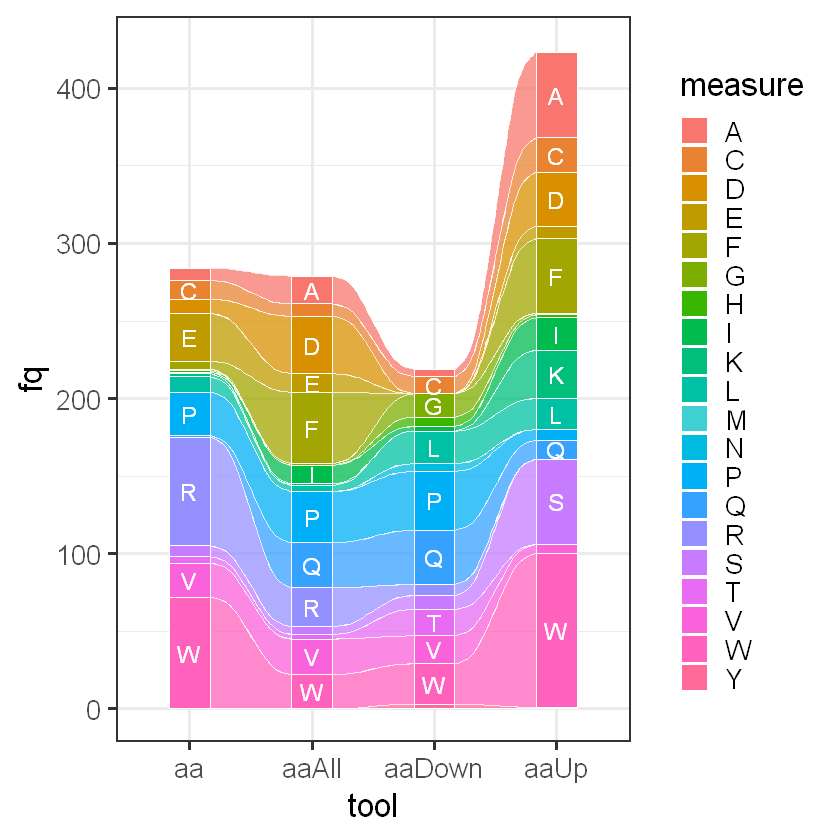

In [10]:
tmp = droplevels(tmp[grepl('^aa',tmp$tool),])
g1=ggplot(data = tmp ,aes(x = tool, y = fq, alluvium = measure)) +
    geom_alluvium(aes(fill = measure),color='white',alpha = .75, decreasing = NA) +
    geom_stratum(aes(stratum = measure,fill=measure),color='white', decreasing = NA, width = 1/3)+
    geom_text(aes(label = ifelse(fq>10,measure,NA)),size=5,color='white', stat = "alluvium")+ylim(0,425)+
    theme_bw(base_size=20) #+ theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = 0)
g1
ggsave(g1,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.05_distr.aa.pdf',width=10,heigh=6)

`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.
Warning message:
"Removed 4 rows containing missing values or values outside the scale range (`geom_text()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range (`geom_text()`)."


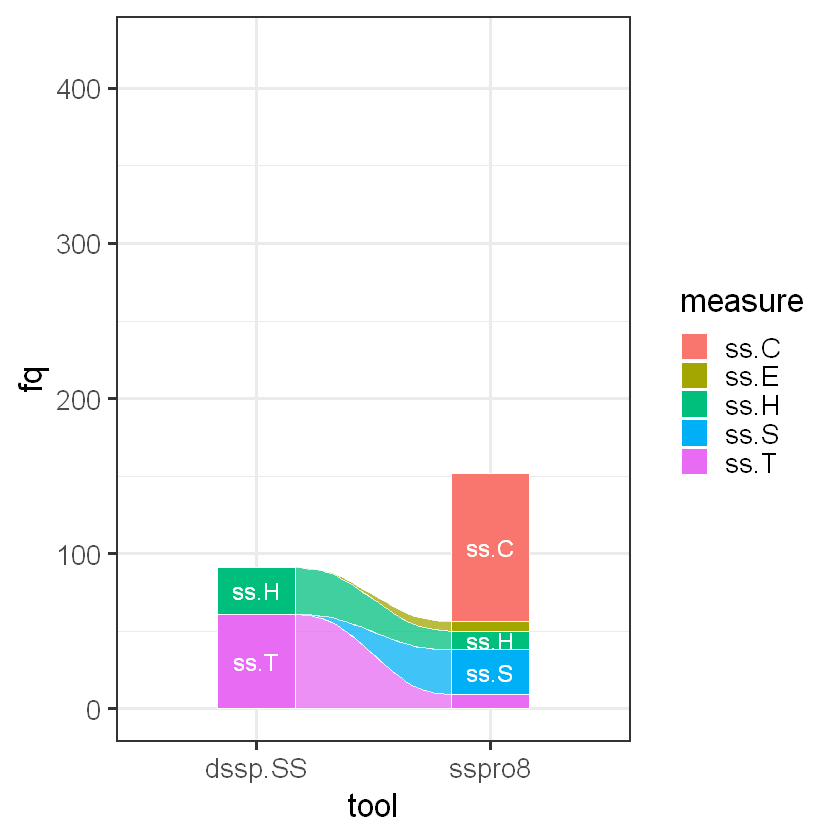

In [11]:




tmp = unique(out[,c('measure','Pr_w','coef','tool','type')]) %>%
        group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.05))
tmp = droplevels(tmp[grepl('sspro8|SS$',tmp$tool),])
g2=ggplot(data = tmp ,aes(x = tool, y = fq, alluvium = measure)) +
    geom_alluvium(aes(fill = measure),color='white',alpha = .75, decreasing = NA) +
    geom_stratum(aes(stratum = measure,fill=measure),color='white', decreasing = NA, width = 1/3)+
    geom_text(aes(label = ifelse(fq>10,measure,NA)),size=5,color='white', stat = "alluvium")+ylim(0,425)+
    theme_bw(base_size=20) #+ theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = 0)
g2
ggsave(g2,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.05_distr.ss.pdf',width=10,heigh=6)


In [12]:
# install.packages('ggalluvial')

`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.
Warning message:
"Removed 53 rows containing missing values or values outside the scale range (`geom_text()`)."
Warning message:
"Removed 53 rows containing missing values or values outside the scale range (`geom_text()`)."
`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.
Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_text()`)."


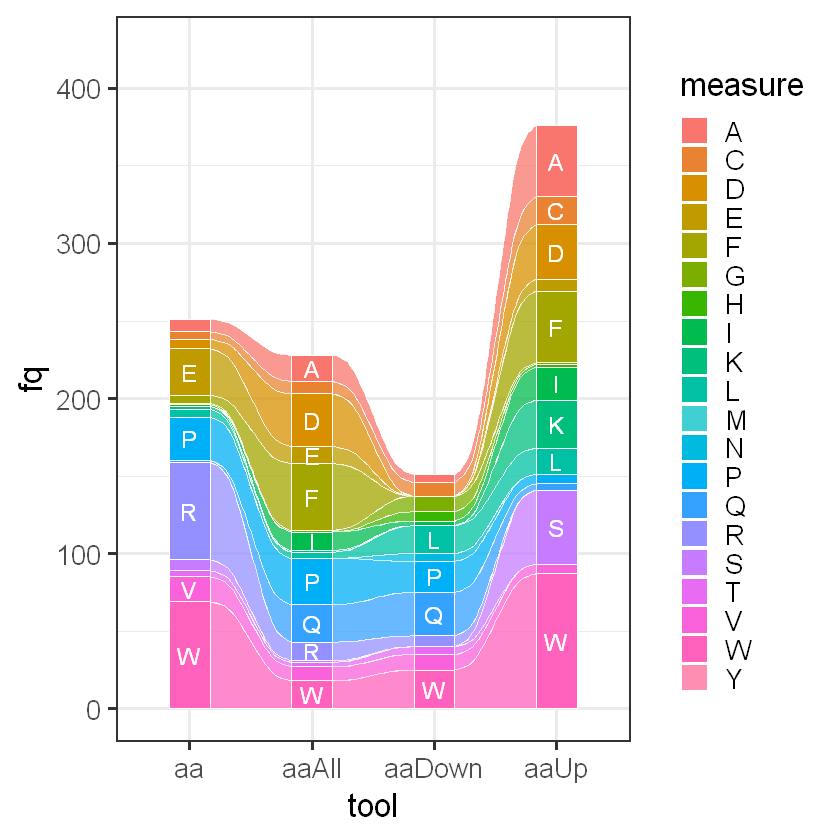

Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_text()`)."


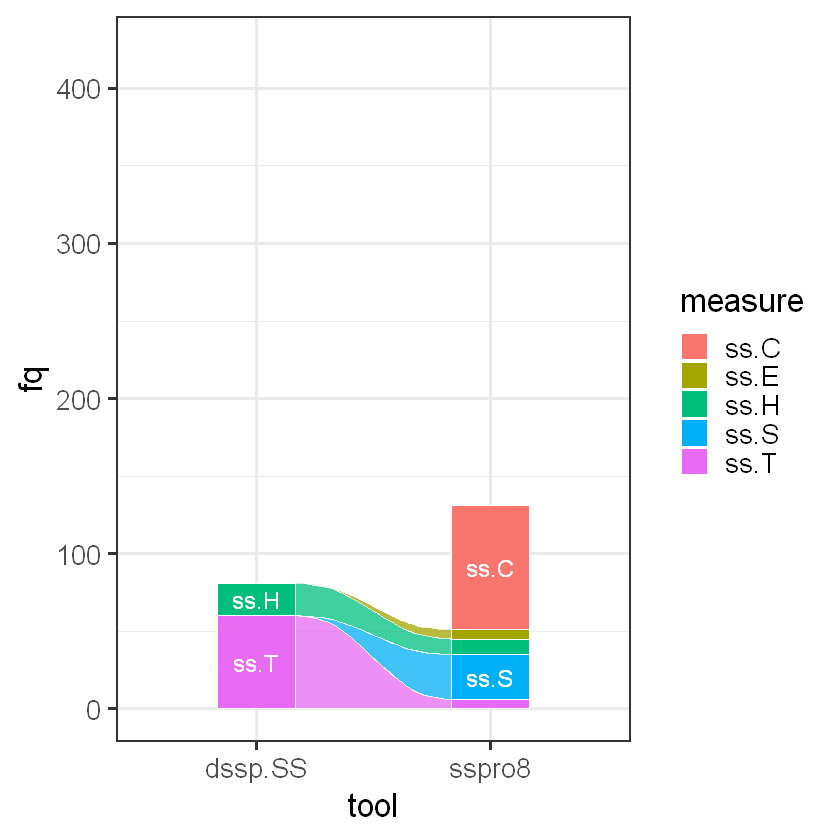

In [13]:


tmp = unique(out[,c('measure','Pr_w','coef','tool','type')])
tmp = tmp %>% group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.1))

write.csv(tmp,file='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.1_distr.all.csv')

tmp = droplevels(tmp[grepl('^aa',tmp$tool),])
g1=ggplot(data = tmp ,aes(x = tool, y = fq, alluvium = measure)) +
    geom_alluvium(aes(fill = measure),color='white',alpha = .75, decreasing = NA) +
    geom_stratum(aes(stratum = measure,fill=measure),color='white', decreasing = NA, width = 1/3)+
    geom_text(aes(label = ifelse(fq>10,measure,NA)),size=5,color='white', stat = "alluvium")+ylim(0,425)+
    theme_bw(base_size=20) #+ theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = 0)
g1
ggsave(g1,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.1_distr.aa.pdf',width=10,heigh=6)

tmp = unique(out[,c('measure','Pr_w','coef','tool','type')]) %>%
        group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.1))
tmp = droplevels(tmp[grepl('sspro8|SS$',tmp$tool),])
g2=ggplot(data = tmp ,aes(x = tool, y = fq, alluvium = measure)) +
    geom_alluvium(aes(fill = measure),color='white',alpha = .75, decreasing = NA) +
    geom_stratum(aes(stratum = measure,fill=measure),color='white', decreasing = NA, width = 1/3)+
    geom_text(aes(label = ifelse(fq>10,measure,NA)),size=5,color='white', stat = "alluvium")+ylim(0,425)+
    theme_bw(base_size=20) #+ theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = 0)
g2
ggsave(g2,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.1_distr.ss.pdf',width=10,heigh=6)

    

`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.
Warning message:
"Removed 48 rows containing missing values or values outside the scale range (`geom_text()`)."
Warning message:
"Removed 48 rows containing missing values or values outside the scale range (`geom_text()`)."
`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.
Warning message:
"Removed 4 rows containing missing values or values outside the scale range (`geom_text()`)."


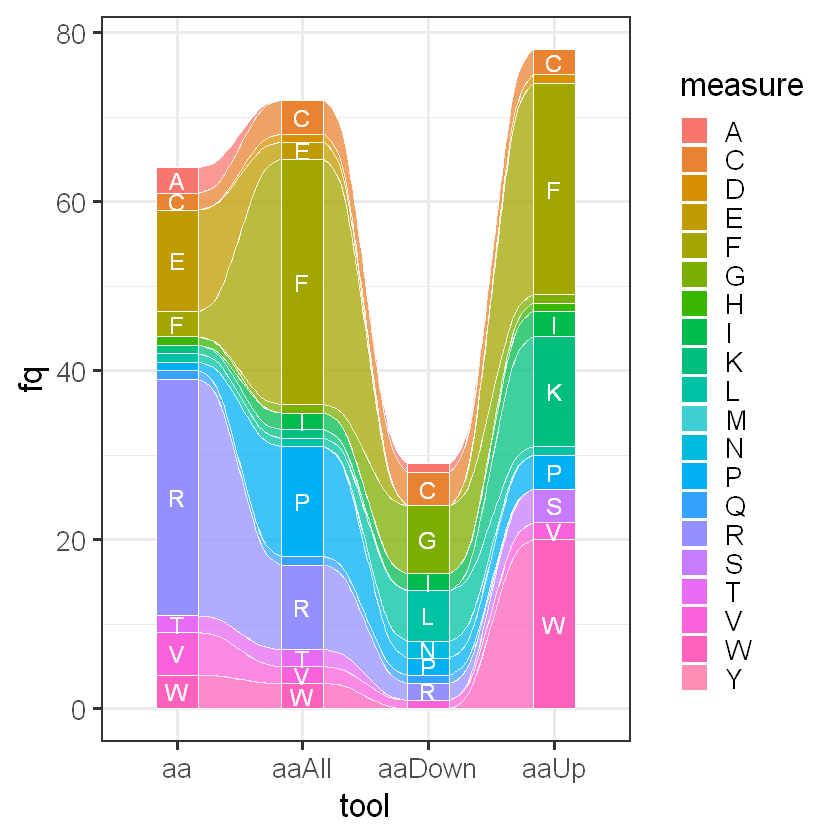

Warning message:
"Removed 4 rows containing missing values or values outside the scale range (`geom_text()`)."


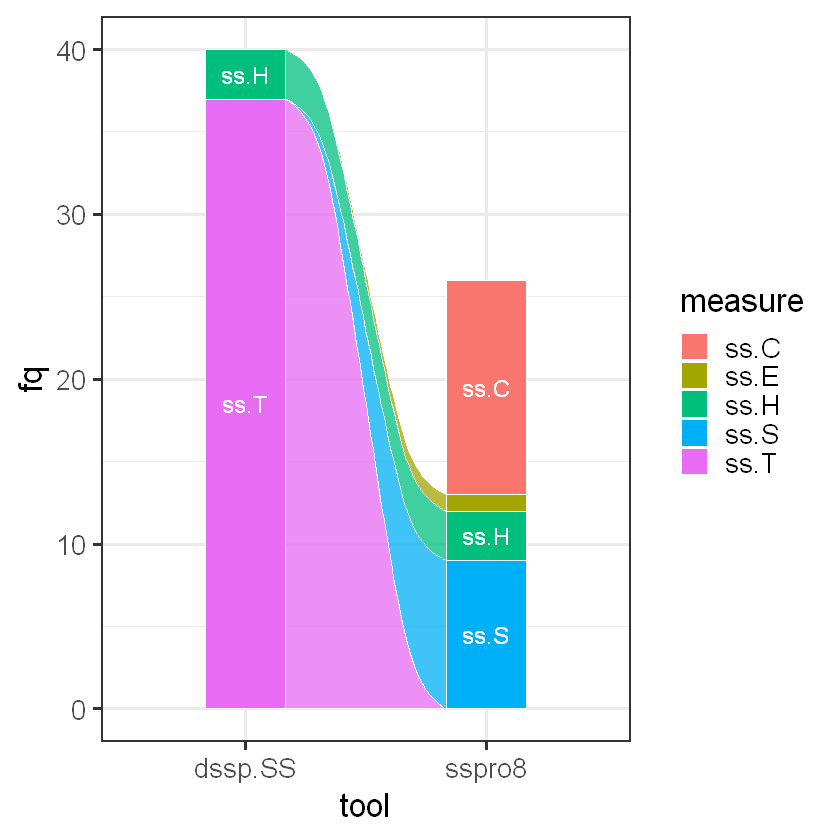

In [14]:
library('alluvial')
library(ggalluvial)

tmp = unique(out[,c('measure','Pr_w','coef','tool','type')])
tmp = tmp %>% group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.5))

write.csv(tmp,file='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.5_distr.all.csv')

tmp = droplevels(tmp[grepl('^aa',tmp$tool),])
g1=ggplot(data = tmp ,aes(x = tool, y = fq, alluvium = measure)) +
    geom_alluvium(aes(fill = measure),color='white',alpha = .75, decreasing = NA) +
    geom_stratum(aes(stratum = measure,fill=measure),color='white', decreasing = NA, width = 1/3)+
    geom_text(aes(label = ifelse(fq>1,measure,NA)),size=5,color='white', stat = "alluvium")+#ylim(0,425)+
    theme_bw(base_size=20) #+ theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = 0)
g1
ggsave(g1,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.5_distr.aa.pdf',width=10,heigh=6)

tmp = unique(out[,c('measure','Pr_w','coef','tool','type')]) %>%
        group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.5))
tmp = droplevels(tmp[grepl('sspro8|SS$',tmp$tool),])
g2=ggplot(data = tmp ,aes(x = tool, y = fq, alluvium = measure)) +
    geom_alluvium(aes(fill = measure),color='white',alpha = .75, decreasing = NA) +
    geom_stratum(aes(stratum = measure,fill=measure),color='white', decreasing = NA, width = 1/3)+
    geom_text(aes(label = ifelse(fq>1,measure,NA)),size=5,color='white', stat = "alluvium")+#ylim(0,425)+
    theme_bw(base_size=20) #+ theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = 0)
g2
ggsave(g2,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.5_distr.ss.pdf',width=10,heigh=6)

    

`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.


type,tool,measure,fq
<fct>,<chr>,<chr>,<int>
seq,aaAll,A,17
seq,aaAll,C,8
seq,aaAll,D,34
seq,aaAll,E,11
seq,aaAll,F,43
seq,aaAll,G,1


`summarise()` has grouped output by 'type', 'tool'. You can override using the `.groups` argument.


type,tool,measure,fq
<fct>,<chr>,<chr>,<int>
seq,aaAll,A,17
seq,aaAll,C,8
seq,aaAll,D,34
seq,aaAll,E,11
seq,aaAll,F,43
seq,aaAll,G,1


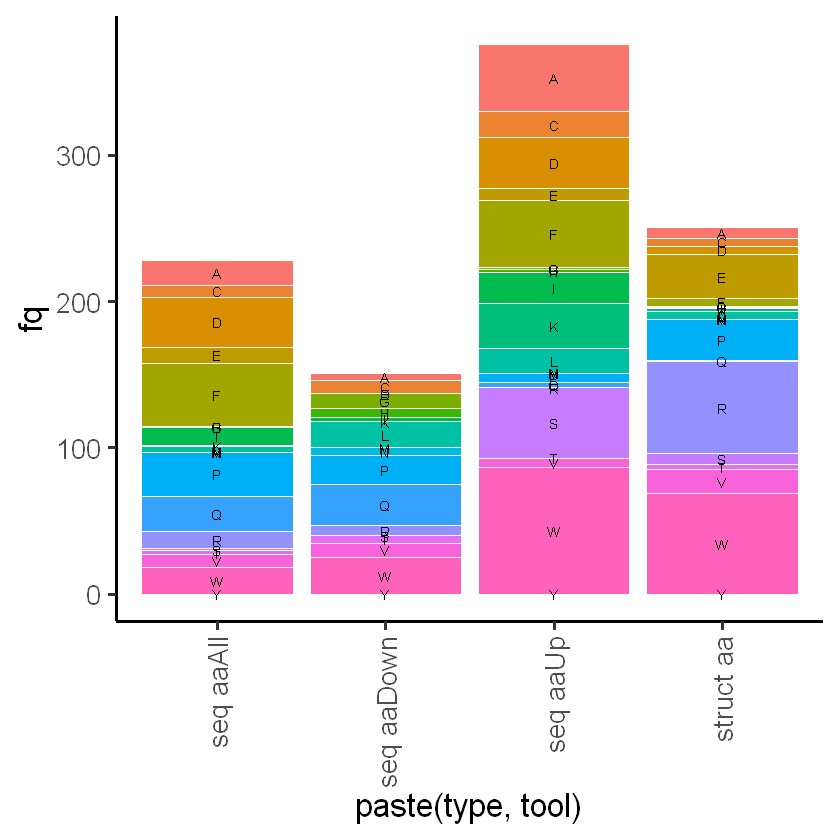

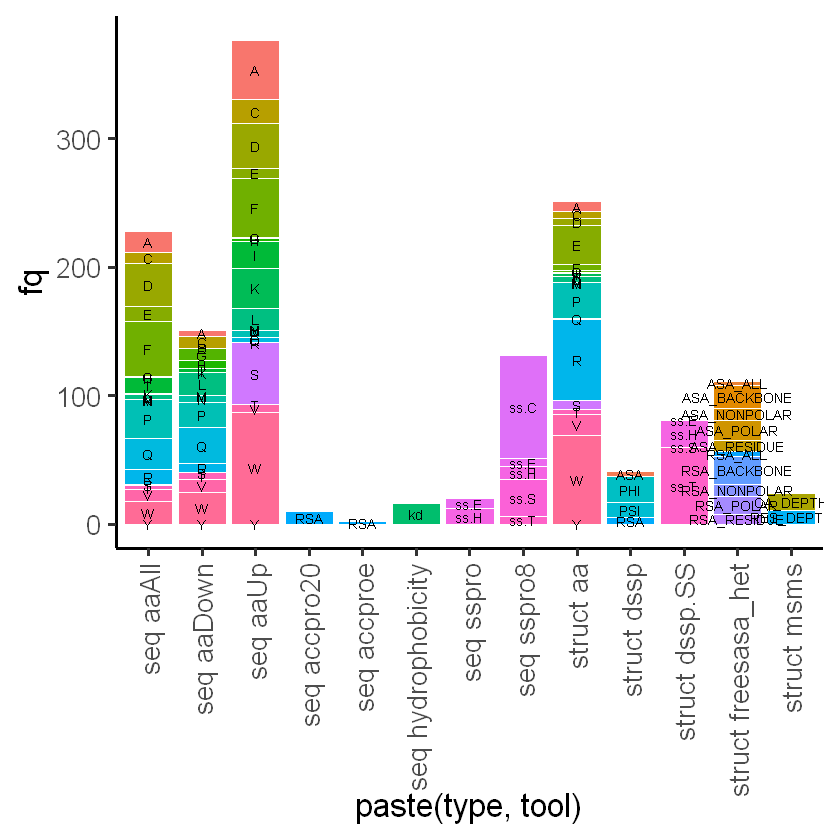

In [15]:

tmp = unique(out[,c('measure','Pr_w','coef','tool','type')]) %>%
        group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.1))
head(tmp)

#head(tmp<-dcast(measure ~ tool,value.var = 'fq',fill=0,data=droplevels(tmp[grepl('^aa',tmp$tool),])))

g=ggplot(data=tmp[grepl('^aa',tmp$tool),],aes(x=paste(type,tool),y=fq,fill=measure,label=measure))+
    geom_bar(stat='identity',color='white')+#facet_grid(type~.,scale='free')+
    geom_text(size = 3, position = position_stack(vjust = 0.5))+
    theme_classic(base_size=20)+#scale_y_log10()+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         legend.text=element_text(size=4),legend.position="none")
g

#str(out)
#tmp = out
tmp = unique(out[,c('measure','Pr_w','coef','tool','type')]) %>%
        group_by(type,tool,measure) %>% summarise(fq=sum(p.adjust(Pr_w,'fdr')<.1 & abs(log(coef))>.1))
head(tmp)

g=ggplot(data=tmp,aes(x=paste(type,tool),y=fq,fill=measure,label=measure))+
    geom_bar(stat='identity',color='white')+#facet_grid(type~.,scale='free')+
    geom_text(size = 3, position = position_stack(vjust = 0.5))+
    theme_classic(base_size=20)+#scale_y_log10()+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         legend.text=element_text(size=4),legend.position="none")
g
ggsave(g,filename='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.1_distr.all.pdf',width=10,heigh=6)
write.csv(tmp,file='figures/03.statistical_trends/glycan_protein_assc/sig.q.1.lgOR.1_distr.all.csv')
